# Can you help reduce employee turnover?

## 📖 Background
You work for the human capital department of a large corporation. The Board is worried about the relatively high turnover, and your team must look into ways to reduce the number of employees leaving the company.

The team needs to understand better the situation, which employees are more likely to leave, and why. Once it is clear what variables impact employee churn, you can present your findings along with your ideas on how to attack the problem.

## 💾 The data
The department has assembled data on almost 10,000 employees. The team used information from exit interviews, performance reviews, and employee records.

- "department" - the department the employee belongs to.
- "promoted" - 1 if the employee was promoted in the previous 24 months, 0 otherwise.
- "review" - the composite score the employee received in their last evaluation.
- "projects" - how many projects the employee is involved in.
- "salary" - for confidentiality reasons, salary comes in three tiers: low, medium, high.
- "tenure" - how many years the employee has been at the company.
- "satisfaction" - a measure of employee satisfaction from surveys.
- "avg_hrs_month" - the average hours the employee worked in a month.
- "left" - "yes" if the employee ended up leaving, "no" otherwise.

## 💪 Competition challenge

Create a report that covers the following:
1. Which department has the highest employee turnover? Which one has the lowest?
2. Investigate which variables seem to be better predictors of employee departure.
3. What recommendations would you make regarding ways to reduce employee turnover?

# Introduction

First, we're going to import the necessary <b>modules and functions</b>. Then import our dataset, where we found that the target variable (left) is on string format. For modeling purpouses, we have to change it to numbers, where 1 means the employee <b>left</b> and 0 that <b>remains</b>. Finally, preview our dataset and type of the variables.

In [1]:
# Import all necessary modules
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Model development
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
# Model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# Import the dataset and change target values to integers
df = pd.read_csv('./data/employee_churn_data.csv')
print(df.shape)
df.loc[df.left == 'no', 'left'] = 0
df.loc[df.left == 'yes', 'left'] = 1
# Convert 'left' to integer
df['left'] = df['left'].astype(int)

# Visualize variable types and table
print(df.dtypes)
df.head()

(9540, 10)
department        object
promoted           int64
review           float64
projects           int64
salary            object
tenure           float64
satisfaction     float64
bonus              int64
avg_hrs_month    float64
left               int64
dtype: object


,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,0
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,0
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,0
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,0
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,0


## EDA preview
Before going deeper into our variable analysis, lets check the <b>total number of employees</b> per department and the proportion of <b>turnover</b>.

Text(0, 0.5, 'Employee count')

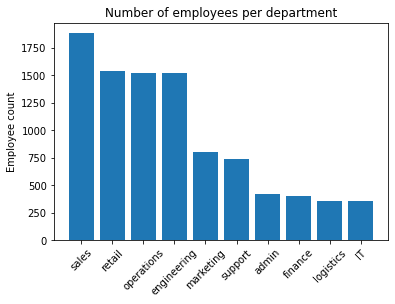

In [2]:
# Number ofemployes per department
department_count = df['department'].value_counts()

# Plot a barchart
plt.bar(department_count.index, department_count)
plt.xticks(rotation=45)
plt.title('Number of employees per department')
plt.ylabel('Employee count')

Sales, retail, operations and engineering are the biggest departments in terms of employee number.

Now let's view the number of turnovers accross the whole company:

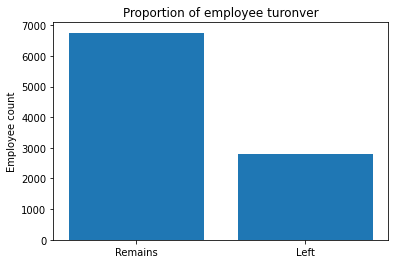

0    6756
1    2784
Name: left, dtype: int64


In [3]:
# Plot a bar chart with the proportion of turnovers
total_turnover = df.left.sum()
plt.bar(['Remains', 'Left'], [df.shape[0] - total_turnover, total_turnover])
plt.title('Proportion of employee turonver')
plt.ylabel('Employee count')
plt.show()

print(df.left.value_counts())

# 1. Highest and Lowest employee turnover
To answer the first question: "Which department has the highest employee turnover? Which one has the lowest?" we're going to look at the <b>turnover rate</b> per department.

department
IT             30.90
logistics      30.83
retail         30.56
marketing      30.30
support        28.84
engineering    28.83
operations     28.65
sales          28.52
admin          28.13
finance        26.87
Name: left, dtype: float64


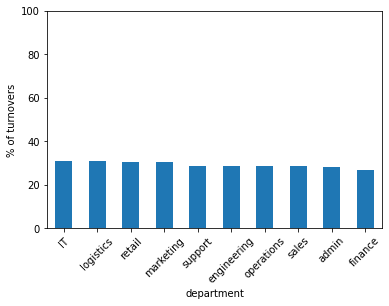

In [4]:
# Turnover rate per department (%)
turnover_dep = df.groupby('department')['left'].sum().sort_values(ascending=False)
turnover_dep_ratio = turnover_dep / df.groupby('department')['left'].count()
turnover_dep_pct = (turnover_dep_ratio * 100).round(2).sort_values(ascending=False)
print(turnover_dep_pct)

# Plot turnover rate
turnover_dep_pct.plot(kind='bar')
plt.xticks(rotation=45)
plt.ylim([0, 100])
plt.ylabel('% of turnovers')
plt.show()

<b>IT</b> had the highest turnover rate with 30.9% and <b>finance</b> had the lowest one with 26.87%. The percentage difference is low, barely <b>4%</b> approximately, so it is presumed that the organizational problems spread throughout the entire company, not by specific departments.

Additionally, we can calculate the total turnovers by department, obtaining the following graphic:

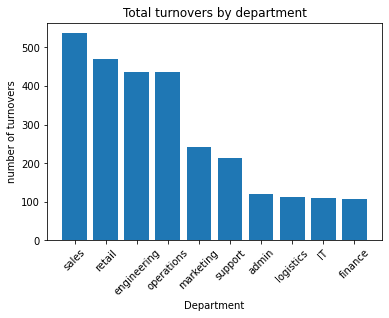

In [5]:
# Plot the total number of turnovers by department
plt.bar(turnover_dep.index, turnover_dep.values)
plt.xticks(rotation=45)
plt.title('Total turnovers by department')
plt.xlabel('Department')
plt.ylabel('number of turnovers')
plt.show()

The <b>sales</b> department had the highest number of turnovers, despite being the third with the lowest rate, due to the large number of employees it has. <b>Finance</b> had the lowest number of turnovers, matching its position with turnover rates.

# 2. Predictors of employee departure
Time to investigate which variables seem to be <b>better predictors</b> of employee departure.

Lets review our dataset again, and then, start doing some <b>EDA</b> to investigate the relationship with each variable and turnover

In [6]:
df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,0
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,0
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,0
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,0
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,0


## Satisfaction rating
One of the variables that could influence departure at first glance is the satisfaction rating by surveys. Let's visualize the results from employee's satisfaction surveys (ranging from 0 to 1).

Mean satisfaction rating: 0.505
Median satisfaction rating: 0.501
Min. satisfaction rating: 0.0
Max. satisfaction rating: 1.0


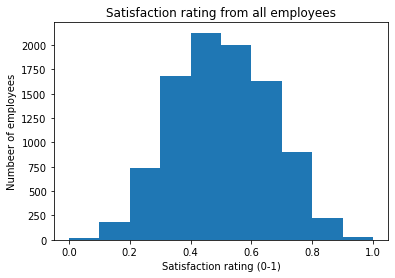

In [7]:
# Summary statistics from satisfaction surveys
print('Mean satisfaction rating:', df.satisfaction.mean().round(3))
print('Median satisfaction rating:', df.satisfaction.median().round(3))
print('Min. satisfaction rating:', df.satisfaction.min().round(3))
print('Max. satisfaction rating:', df.satisfaction.max().round(3))

# Plot a histogram
plt.hist(df['satisfaction'])
plt.xlabel('Satisfaction rating (0-1)')
plt.ylabel('Numbeer of employees')
plt.title('Satisfaction rating from all employees')
plt.show()

Satisfaction rating looks normally distributed around 0.5, this does not speak very well of the well-being of the employees in this company

Now we are going to see the results of the surveys depending on whether the employee left or not.

Mean satisfaction rating for employees who left: 0.502
Median satisfaction rating for employees who left: 0.491 

Mean satisfaction rating for employees who remains: 0.506
Median satisfaction rating for employees who remains: 0.504 

The average satisfaction rate is 0.68 % higher on employees who remains
The median satisfaction rate is 2.57 % higher on employees who remains


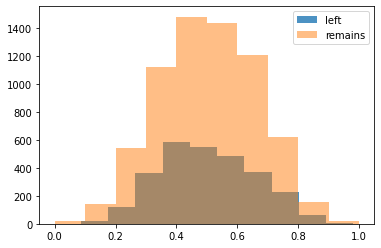

In [8]:
# Create two datasets containing employees that left and remain, respecively.
df_yes = df[df['left'] == 1]
df_no = df[df['left'] == 0]

# Summary statistics for satisfaction rating per employee outcome:
print('Mean satisfaction rating for employees who left:', df_yes.satisfaction.mean().round(3))
print('Median satisfaction rating for employees who left:', df_yes.satisfaction.median().round(3), '\n')
print('Mean satisfaction rating for employees who remains:', df_no.satisfaction.mean().round(3))
print('Median satisfaction rating for employees who remains:', df_no.satisfaction.median().round(3), '\n')

# Calculate percentage difference of the summary statistics
pct_mean_satis = (df_no.satisfaction.mean() - df_yes.satisfaction.mean())*100 / df_yes.satisfaction.mean()
print('The average satisfaction rate is', pct_mean_satis.round(2),'% higher on employees who remains')
pct_median_satis = (df_no.satisfaction.median() - df_yes.satisfaction.median())*100 / df_yes.satisfaction.median()
print('The median satisfaction rate is', pct_median_satis.round(2),'% higher on employees who remains')

# Plot a histogram of satisfaction distribution by employee condition
plt.hist(df_yes['satisfaction'], alpha=0.8, label='left')
plt.hist(df_no['satisfaction'], alpha=0.5, label='remains')
plt.legend(loc='upper right')
plt.show()

Satisfaction rating doesn't seem as important enough as expected to influence the exit of the employees, since only a difference of <b>less than 3%</b> is seen in the median of ratings. Also, both histograms show a very similar trend.

## Promotions
May employees who received a promotion in the last 24 months tend to stay with the company longer than those who didn't?

In [9]:
# Percentage of employees who received a promotion recently, from the group that left the company
prom_who_left = df_yes.groupby('promoted')['left'].count()
print(prom_who_left, '\n')
print('From the employees that left,', (prom_who_left[1]*100/prom_who_left[0]).round(1),'% of them recieved a promotion in the last 24 months \n')

# Percentage of employees who received a promotion recently, from the group that remains
prom_who_remains = df_no.groupby('promoted')['left'].count()
print(prom_who_remains, '\n')
print('From the employees that remains,', (prom_who_remains[1]*100/prom_who_remains[0]).round(1),'% of them recieved a promotion in the last 24 months \n')

promoted
0    2727
1      57
Name: left, dtype: int64 

From the employees that left, 2.1 % of them recieved a promotion in the last 24 months 

promoted
0    6524
1     232
Name: left, dtype: int64 

From the employees that remains, 3.6 % of them recieved a promotion in the last 24 months 



Promotions do not seem to be a variable that greatly influences exits, however, there is a <b>slight favorable tendency to stay when they receive promotions</b>.

## Reviews 
Let's see if the last complete evaluation carried out on each employee marks any trend on turnovers. The reviews, like the satisfaction surveys, range from 0 to 1.

Mean review rating: 0.652
Median review rating: 0.647
Min. review rating: 0.31
Max. reviewrating: 1.0


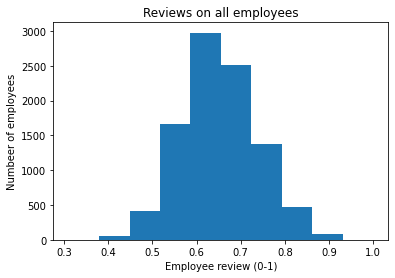

In [10]:
# Summary statistics of review in the whole company
print('Mean review rating:', df.review.mean().round(3))
print('Median review rating:', df.review.median().round(3))
print('Min. review rating:', df.review.min().round(3))
print('Max. reviewrating:', df.review.max().round(3))

# Plot a histogram of reviews' distribution
plt.hist(df['review'])
plt.xlabel('Employee review (0-1)')
plt.ylabel('Numbeer of employees')
plt.title('Reviews on all employees')
plt.show()

Reviews look normally distributed around 0.65, higher than the mean of 0.5 for satistaction values. Let's look at how the reviews vary whether an employee left or remains:

Mean review for employees who left: 0.692
Median review for employees who left: 0.698 

Mean review for employees who remains: 0.635
Median review for employees who remains: 0.635 

The average review rate is 8.25 % lower on employees who remains
The median review rate is 9.11 % lower on employees who remains


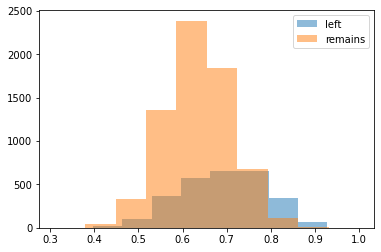

In [11]:
# Summary statistics depending on employee outcome
print('Mean review for employees who left:', df_yes.review.mean().round(3))
print('Median review for employees who left:', df_yes.review.median().round(3), '\n')
print('Mean review for employees who remains:', df_no.review.mean().round(3))
print('Median review for employees who remains:', df_no.review.median().round(3), '\n')

# % Difference in summary statistics
pct_mean_review = (df_yes.review.mean() - df_no.review.mean())*100 / df_yes.review.mean()
print('The average review rate is', pct_mean_review.round(2),'% lower on employees who remains')
pct_median_review = (df_yes.review.median() - df_no.review.median())*100 / df_yes.review.median()
print('The median review rate is', pct_median_review.round(2),'% lower on employees who remains')

# Histograms for reviews on 'left' and 'remains' employees
plt.hist(df_yes['review'], alpha=0.5, label='left')
plt.hist(df_no['review'], alpha=0.5, label='remains')
plt.legend(loc='upper right')
plt.show()

We can see in the histograms the trend that <b>employees with better qualifications tend to leave the company more often</b>. This variable proves to have much more weight than satisfaction rating and any other variable so far.

Could top performing employes feel that the company is not offering them the opportunities they aspire to?

Let's view the 'projects' variable, as this may be related to reviews, and show a same trend.

## Projects
Let's see how the number of projects an employee is involved in is related to the turnover rate

Mean number of projects per employee: 3.275
2     578
3    5833
4    3058
5      71
Name: projects, dtype: int64


Text(0.5, 1.0, 'Projects')

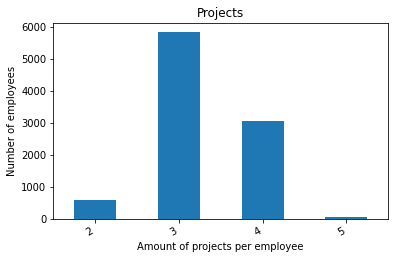

In [12]:
# Compute mean projects per employee
print('Mean number of projects per employee:', df.projects.mean().round(3))

# Number of projects per employee
project_count = df['projects'].value_counts().sort_index()
print(project_count)

# Plot number of projects per employee
ax = project_count.plot(kind='bar')
fig = ax.get_figure()
fig.autofmt_xdate()
plt.xlabel('Amount of projects per employee')
plt.ylabel('Number of employees')
plt.title('Projects')

In [13]:
# Mean project involving per type of employee outcome:
print('Mean number of projects per employee who left:', df_yes.projects.mean().round(3))
print('Mean number of projects per employee who remains:', df_no.projects.mean().round(3))
print('% increase:', ((df_no.projects.mean()-df_yes.projects.mean())*100 / df_yes.projects.mean()).round(2))

Mean number of projects per employee who left: 3.264
Mean number of projects per employee who remains: 3.279
% increase: 0.48


In [14]:
# Project count of those who left
project_count_yes = df_yes['projects'].value_counts().sort_index()
print(project_count_yes)

# Project count of those who remain
project_count_no = df_no['projects'].value_counts().sort_index()
print(project_count_no)

2     175
3    1720
4     869
5      20
Name: projects, dtype: int64
2     403
3    4113
4    2189
5      51
Name: projects, dtype: int64


Projects do not seem to be a variable that greatly influences exits, however, there is a <b>slight favorable tendency to stay for those who participate in more projects</b>.

## Salary
The data on wage amounts is grouped into three categorical variables for confidentiality: <b>low, medium and high</b> wages.
Let's see how the variable behaves with respect to turnovers:

   salary  employees  employee_pct
0  medium       1951          70.1
1    high        442          15.9
2     low        391          14.0
   salary  employees  employee_pct
0  medium       4660          69.0
1    high       1106          16.4
2     low        990          14.7


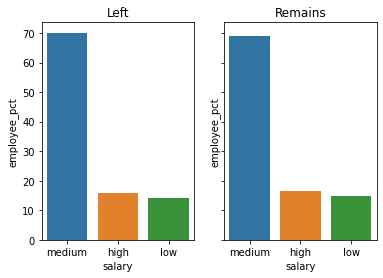

In [15]:
# Salary levels per number of employees who left
salary_yes = df_yes['salary'].value_counts()
salary_yes = pd.DataFrame(salary_yes).reset_index()
salary_yes = salary_yes.rename(columns = {'index':'salary', 'salary':'employees'})
salary_yes['employee_pct'] = (salary_yes['employees']*100 / salary_yes['employees'].sum()).round(1)
print(salary_yes)

# Salary levels per number of employees who remains
salary_no = df_no['salary'].value_counts()
salary_no = pd.DataFrame(salary_no).reset_index()
salary_no = salary_no.rename(columns = {'index':'salary', 'salary':'employees'})
salary_no['employee_pct'] = (salary_no['employees']*100 / salary_no['employees'].sum()).round(1)
print(salary_no)

# Plot the two graphs
fig, ax =plt.subplots(1,2,sharey=True)
sns.barplot(x='salary', y='employee_pct', data=salary_yes, ax=ax[0]).set_title('Left')
sns.barplot(x='salary', y='employee_pct', data=salary_no, ax=ax[1]).set_title('Remains')
fig.show()

A similar proportion can be seen between the salaries of those who left and those who remains, with a slightly favored trend on "high salarys" towards the second group. We can suppose that this variable has <b>little effect on turnovers</b>.

## Tenure
Referring to the number of years in the company. Let's see its relationship with turnovers:

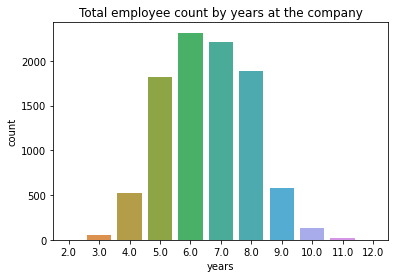

Left:
Mean: 6.58
Median: 7.0 

Remains:
Mean: 6.55
Median: 6.0 



In [16]:
# Plot tenure per count of employees
tenure = df['tenure'].value_counts().sort_index().reset_index()
tenure = tenure.rename(columns = {'index':'years', 'tenure':'count'})
sns.barplot(x='years', y='count', data=tenure)
plt.title('Total employee count by years at the company')
plt.show()

# Summary statistics on tenure for those who left
print('Left:')
print('Mean:', df_yes['tenure'].mean().round(2))
print('Median:', df_yes['tenure'].median().round(2), '\n')

# Summary statistics on tenure for those who remains
print('Remains:')
print('Mean:', df_no['tenure'].mean().round(2))
print('Median:', df_no['tenure'].median().round(2), '\n')

Employees who left had a slightly longer tenure than those who stayed. However, the difference is very small, so little relationship with turnovers is expected.

## Bonus
A variable that is not explained with details like the others, but we're going to asume that '1' refers to employees who received a monetary bonus recently and '0' otherwise.

In [17]:
# Percentage of employees who received a bonus from the group who left
bonus_left = df_yes.groupby('bonus')['left'].count()
bonus_left = pd.DataFrame(bonus_left).reset_index()
bonus_left = bonus_left.rename(columns={'left':'count'})
bonus_left.replace({0:'no', 1:'yes'}, inplace=True)
bonus_left['pct'] = (bonus_left['count']*100 / bonus_left['count'].sum()).round(1)
print('Left:')
print(bonus_left, '\n')

# Percentage of employees who received a bonus from the group who remains
bonus_remains = df_no.groupby('bonus')['left'].count()
bonus_remains = pd.DataFrame(bonus_remains).reset_index()
bonus_remains = bonus_remains.rename(columns={'left':'count'})
bonus_remains.replace({0:'no', 1:'yes'}, inplace=True)
bonus_remains['pct'] = (bonus_remains['count']*100 / bonus_remains['count'].sum()).round(1)
print('Remains:')
print(bonus_remains)

Left:
  bonus  count   pct
0    no   2214  79.5
1   yes    570  20.5 

Remains:
  bonus  count   pct
0    no   5303  78.5
1   yes   1453  21.5


<b>21.5%</b> of employees who remains received a bonus recently, just a litte bit higher from those who left and received the bonus (<b>20.5 %</b>). Employees with an economic bonus tend to leave the company less, but the difference is not very significant to declare correlation.

## Average hours worked in a month

In [18]:
# Summary statistics for avg. hours worked per month
print('Max.:', df['avg_hrs_month'].max())
print('Min.:',df['avg_hrs_month'].min())
print('Median:',df['avg_hrs_month'].median(), '\n')
      
# Compute the mean of the avg. hours worked per month by type of employee outcome (0: remains, 1: left)
avg_hrs_month = df.groupby('left')['avg_hrs_month'].mean()
print('Mean avg. hours worked in a month grouped by turnover:')
print(avg_hrs_month, '\n')
hrs_increase = (100*(avg_hrs_month[1] - avg_hrs_month[0]) / avg_hrs_month[0]).round(2)
# % difference
print('Those who left worked, on average,', hrs_increase, '% more hours than those who remains')

Max.: 200.8616558715116
Min.: 171.37406048199938
Median: 184.62879553610867 

Mean avg. hours worked in a month grouped by turnover:
left
0    184.637605
1    184.719730
Name: avg_hrs_month, dtype: float64 

Those who left worked, on average, 0.04 % more hours than those who remains


Due to such a low difference in means, this variable <b>doesn't seem to be important at all to predict turnovers.</b>

Now that we've studied the realtionship between each variable from our dataset and the target (left or remains), lets compute the correlation between them, to compare our findings from EDA and a statistical computation.

## Correlation heat map

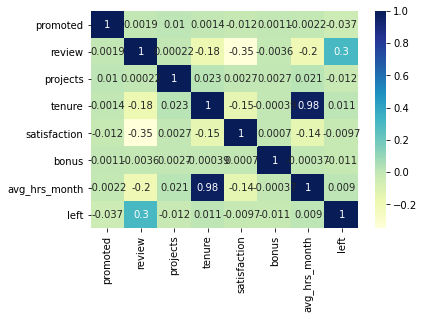

In [19]:
# plotting correlation heatmap
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

As expected, the variable with the highest correlation with turnovers is <b>reviews</b>, in agreement with the EDA, followed by <b>promotions</b>, and then, with a very low correlation, number of <b>projects, tenure, bonus, satisfaction and average hours worked</b>.

# Predictor variables of turnovers
Considering the EDA and correlation map made, let's classify our features in terms of how important are they to predict whether an employee leaves or remains. The Pearson correlation coefficient of each variable vs. 'left' is written in parentheses, and one highlight of our previous analysis is shown for each variable. 

<u>High level predictor:</u>
- <b>review (0.3)</b>: The median review rate is 9.11% lower on those who remains

<u>Medidum level predictor:</u>
- <b>promoted (-0.037)</b>: Among the workers who stayed, 3.6% received promotions, while of those who left, only 2.1% received promotions recently.

<u>Low level predictors:</u>
- <b>tenure (0.011)</b>: The average tenure in years for those who left was 6.58 years, while for those who stayed its 6.55.
- <b>satisfaction (-0.0097)</b>: The median satisfaction rate is 2.57 % higher on employees who remains
- <b>projects (-0.012)</b>: Employees who remain are involved, on average, in 0.48% more projects (3.28) than those who left (3.26).
- <b>bonus (-0.011)</b>: 21.5% of employees who remains received a bonus recently, while only 20.5% of those who left received it.
- <b>avg_hours_month (0.009)</b>
- <b>salary</b>: For those who remains, 16.4% receive a high salary, and for those who left: 15,9%
- <b>department</b>: theres only 4% difference from highest (IT) to lowest (finance) turnover for a department.

## Are "salary" and "department" variables are worth it for model development?
Using the correlation matrix for all dummy variables, we're going to check if there's enough correlation to include the features department and salary. 

The reason for this check is because these two categorical variables require the creation of more variables, which increases the dimensionality of the model. The higher the number of features, the more difficult it is to model them.

If we don't find a significant correlation, we won't use them to develop our model.

In [20]:
# Create dummy variables for each type of department and salary category
df_dum = pd.get_dummies(df)

# Compute the correlation matrix
df_dum.corr()

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month,left,department_IT,department_admin,...,department_finance,department_logistics,department_marketing,department_operations,department_retail,department_sales,department_support,salary_high,salary_low,salary_medium
promoted,1.000000,0.001879,0.010107,0.001410,-0.011704,0.001072,-0.002190,-0.036777,-0.008985,0.009465,...,0.020767,-0.012535,0.021389,-0.001848,0.008837,-0.010822,0.001684,-0.001484,-0.003190,0.003619
review,0.001879,1.000000,0.000219,-0.184133,-0.349778,-0.003627,-0.196096,0.304294,-0.009418,-0.011971,...,0.007642,0.005914,0.020838,0.008021,-0.008615,-0.001135,-0.004606,-0.000951,0.004773,-0.002881
projects,0.010107,0.000219,1.000000,0.022596,0.002714,0.002654,0.021299,-0.012408,0.004924,0.001531,...,0.006769,0.000054,0.002985,-0.002625,-0.006656,0.009764,-0.003400,-0.011025,0.021319,-0.007450
tenure,0.001410,-0.184133,0.022596,1.000000,-0.146246,-0.000392,0.978618,0.010521,0.007423,-0.008730,...,-0.017173,-0.003975,-0.011226,0.016076,0.010851,-0.007126,0.001723,0.007638,-0.000019,-0.006091
satisfaction,-0.011704,-0.349778,0.002714,-0.146246,1.000000,0.000704,-0.143142,-0.009721,0.013875,0.020107,...,-0.009871,-0.014439,-0.004268,-0.000067,-0.005193,-0.000389,0.003526,-0.006056,0.000752,0.004267
bonus,0.001072,-0.003627,0.002654,-0.000392,0.000704,1.000000,-0.000370,-0.011485,0.004747,-0.013328,...,0.009897,-0.001803,0.005482,-0.005425,0.007124,-0.000192,-0.005635,0.001905,0.013230,-0.011615
avg_hrs_month,-0.002190,-0.196096,0.021299,0.978618,-0.143142,-0.000370,1.000000,0.009008,0.007571,-0.006416,...,-0.014496,-0.003423,-0.014006,0.015814,0.007784,-0.005364,-0.001307,0.011134,-0.000448,-0.008558
left,-0.036777,0.304294,-0.012408,0.010521,-0.009721,-0.011485,0.009008,1.000000,0.007434,-0.004975,...,-0.010689,0.007192,0.007443,-0.005136,0.013345,-0.007244,-0.002154,-0.006093,-0.007870,0.010874
department_IT,-0.008985,-0.009418,0.004924,0.007423,0.013875,0.004747,0.007571,0.007434,1.000000,-0.042409,...,-0.041295,-0.038989,-0.059647,-0.085779,-0.086416,-0.097635,-0.056884,0.001851,-0.013414,0.008753
department_admin,0.009465,-0.011971,0.001531,-0.008730,0.020107,-0.013328,-0.006416,-0.004975,-0.042409,1.000000,...,-0.045178,-0.042655,-0.065257,-0.093847,-0.094543,-0.106817,-0.062233,-0.002262,-0.016257,0.014209


We can see that all dummy variables (salary level and department categories) have an absolute correlation coefficient less than 0.013. For that reason, we are eliminating them from our model, to achieve more efficiency

# Model development: Logistic regression
We will perform a Logistic Regression to predict Employee turnover using all of the variables in our dataset, excepting salary, department and avg_hours_month.

From the heat correlation map, we observed how the variables tenure and avg_month_work have a correlation of 0.98, so they are redundant. We'll remove the second one, since it correlates less with 'left':

## Splitting the dataset into train and test sets
Now, we will split our data into train set and test set to prepare our data for two different phases of machine learning modeling: training and testing.

Ideally, no information from the test data should be used to preprocess the training data or should be used to direct the training process of a machine learning model. Hence, we first split the data and then preprocess it.

In [21]:
# Drop useless features: avg_hrs_month, department, salary
df_model = df.drop(['avg_hrs_month', 'department', 'salary'], axis=1)
print(df_model.head())

# Split into train ant test splits with test size = 30%
train, test = train_test_split(df_model, test_size = 0.3, random_state=50)

   promoted    review  projects  tenure  satisfaction  bonus  left
0         0  0.577569         3     5.0      0.626759      0     0
1         0  0.751900         3     6.0      0.443679      0     0
2         0  0.722548         3     6.0      0.446823      0     0
3         0  0.675158         4     8.0      0.440139      0     0
4         0  0.676203         3     5.0      0.577607      1     0


## Check for missing values that could affect our model

If no missing values found, we can continue.

In [22]:
# Check for null values
print(train.isnull().sum())
print(test.isnull().sum())

promoted        0
review          0
projects        0
tenure          0
satisfaction    0
bonus           0
left            0
dtype: int64
promoted        0
review          0
projects        0
tenure          0
satisfaction    0
bonus           0
left            0
dtype: int64


## Data preprocessing: scaling features
Scale the feature values to a uniform range (0-1), because models like logistic regressions are very sensitive to the range of the data points.

In [23]:
# Segregate features and labels into separate variables
X_train, y_train = train.iloc[:, :-1].values, train.iloc[:, [-1]].values
X_test, y_test = test.iloc[:, :-1].values, test.iloc[:, [-1]].values

# Instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = MinMaxScaler(feature_range=(0,1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)

## Fitting a logistic regression model to the train set
Predicting if an employee will leave or not is a classification task. Our dataset contains more instances that correspond to "Remains" than instances corresponding to "Left". Specifically, out of 9540 instances, there are 6756 (70,8%) employees that remains and 2784 (29,2%) employees that left.

This gives us a benchmark. A good machine learning model should be able to accurately predict the decision of an employee with respect to these statistics.

In [24]:
# Instantiate a LogisticRegression classifier with default parameter values
logreg = LogisticRegression()

# Fit logreg to the train set
logreg.fit(rescaledX_train, y_train)

LogisticRegression()

## Making predictions and evaluating performance
Time to check how well does our model perform:

We will now evaluate our model on the test set with respect to classification accuracy. But we will also take a look the model's confusion matrix and other model's

In [25]:
# Use logreg to predict instances from the test set and store it
y_pred = logreg.predict(rescaledX_test)

# Get the accuracy score of logreg model and print it
print("Accuracy of logistic regression classifier:", logreg.score(rescaledX_test, y_test), '\n')

# Print the confusion matrix of the logreg model
print('Confusion matrix: \n', confusion_matrix(y_test,y_pred), '\n')

# Print the classification report
print('Classification report: (0: remains,  1: left)\n', classification_report(y_test, y_pred), '\n')

# Number of remains (0) and turnovers (1) predicted:
unique_elements, counts_elements = np.unique(y_pred, return_counts=True)
print("Frequency of unique values of the prediction array: (0: remains,  1: left)")
print(np.asarray((unique_elements, counts_elements)))

Accuracy of logistic regression classifier: 0.7337526205450734 

Confusion matrix: 
 [[1931   88]
 [ 674  169]] 

Classification report: (0: remains,  1: left)
               precision    recall  f1-score   support

           0       0.74      0.96      0.84      2019
           1       0.66      0.20      0.31       843

    accuracy                           0.73      2862
   macro avg       0.70      0.58      0.57      2862
weighted avg       0.72      0.73      0.68      2862
 

Frequency of unique values of the prediction array: (0: remains,  1: left)
[[   0    1]
 [2605  257]]


## Results
For the confusion matrix:
- <b>1931</b>: The first element of the of the first row denotes the true negatives (employee <b>remains</b> or '0') predicted by the model <b>correctly</b>. 
- <b>169</b>: The last element of the second row denotes the true positives (employee <b>left</b> or '1') predicted by the model <b>correctly</b>.

- <b>674</b>: The first element of the second row denots the false negatives (employee <b>remains</b> or '0') predicted by the model <b>incorrectly</b>.
- <b>88</b>: The last element of the first row denotes the false positives (employee <b>left</b> or '1') predicted by the model <b>incorrectly</b>.

Our model was able to yield an accuracy score of 73,3%. However, it was only able to correctly predict 169 of the 843 employees who left (recall = 0.20). For this reason, we consider that our model is not satisfactory, and it is recommended to look for other types of variables to predict with greater precision.

# 3. Conclusions and final recommendations regarding ways to reduce employee turnover
The company is going through a major employee turnover crisis, with almost 30% of employees recently resigning.

From the study of the variables carried out, <b>reviews</b> represented the best predictor, followed by <b> promoted </b>, with 0.3 and 0.03 correlation coeficientes with <b>turnover</b>, respectively. However, the correlation coefficients, and therefore the predictive capacities, are very low in general for the entire group of variables.

That said, we recommend the following actions:

## Investigate and collect other kind of variables.
In the surveys, not only ask about satisfaction rating, but also about variables such as: employee's opinion about the <b>work environment</b>, <b>challenges</b>, <b>autonomy</b> and <b>overload of responsibilities</b>, and use them as new variables to improve the predictive capacity of the model.

Not only variables intrinsically related to work could be included in the analysis. Aspects such as the <b> psychological state</b> of the employee or the time it takes to get to work <b>(commute)</b> could add value to finding the causes of turnovers. Innovative companies today have free psychology services that employees can take at any time and also, flexibility towards more remote work time.

## Grant more acttractive opportunities to stay to employees with better reviews.
We saw how, on average, employees with better reviews tend to leave the company more. Therefore, the company must improve aspects so that the most qualified employees decide to continue making a career in the company. These aspects could be investigated through surveys, but it is assumed in advance that they can be better salaries, growth opportunities, challenges and extra benefits.

It is important to act fast because, as being highly qualified employees, they are more in demand by other companies, so they can move to workplaces where they are more satisfied.

## Give promotions more often, as long as they are deserved.
Promotions was the second most important variable to predict turnovers, since employees who received promotions recently tended to stay with the company longer.

Therefore, it is important to guarantee growth opportunities within the company and to grant promotions precisely to the employees who most deserve them.

## Final thoughts
If you made it this far, thank you so much for reading!

I am attentive in the comments to any questions and suggestions you have.